In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# Read in data
df = pd.read_csv('data/movielens-100k.csv', sep='\t', header=None, names=["user_id", "item_id", "rating", "timestamp"])
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [2]:
df.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


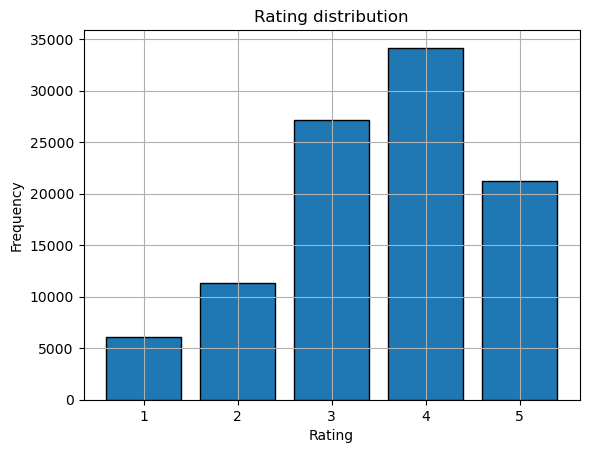

In [3]:
# Looking at distribution of ratings 

bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
bin_centers = [1, 2, 3, 4, 5]  # Centers of the bins

# Plotting the histogram
plt.hist(df['rating'], bins=bins, edgecolor='black', rwidth=0.8)
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Set the x-ticks at the center of each bin
plt.xticks(bin_centers)

plt.grid(True)
plt.show()

In [4]:
# Convince ourselves that every user_id and movie_id is being used 
# since we will be creating an embedding table from [1..max(id)]

assert df['user_id'].nunique() == max(df['user_id'])
assert df['item_id'].nunique() == max(df['item_id'])

In [138]:
# Let's build our model! 

import torch
from torch import nn
import torch.nn.functional as F

class SimpleMatrixFactorization(nn.Module): 
    
    def __init__(self, embedding_dim, num_users, num_movies): 
        super().__init__()
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_movies, embedding_dim)
        self.user_bias = nn.Parameter(torch.zeros(num_users, 1))
        self.item_bias = nn.Parameter(torch.zeros(num_movies, 1))
        
    def forward(self, x): 
        
        x.shape # B x 2
        
        # we need to subtract from 1 to get a user_id 
        user_embeddings = self.user_embedding(x[:, 0]) # B, embed_dim
        item_embeddings = self.item_embedding(x[:, 1]) # B, embed_dim
        user_bias = self.user_bias[x[:, 0]].squeeze()
        item_bias = self.item_bias[x[:, 1]].squeeze()
        
        # summing over columns of elementwise multiplication 
        predicted_ratings = torch.sum(user_embeddings * item_embeddings, dim=1) + user_bias + item_bias # B, 1
        normalized_ratings = torch.sigmoid(predicted_ratings)*5.5 #clamp ratings between 0-5.5
        return predicted_ratings

In [144]:
# Get our training dataset all setup
torch.manual_seed(17)
data = torch.tensor(df[['user_id', 'item_id', 'rating']].to_numpy())
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()

train_data = data[:int(0.8*len(data))]
test_data = data[int(0.8*len(data)):]

# Hyper parameters 
batch_size = 50
max_iters = 100000
eval_iters = 10000
lr = 1e-3
embedding_dim = 50

# validation loss is the average loss of a 100 batches from the test data
@torch.no_grad()
def get_val_loss(data): 
    loss = 0
    iters = 100
    for i in range(iters):
        ix = torch.randint(len(data), (batch_size, ))
        batch_x, batch_y = data[ix, :2] - 1, data[ix, -1].float()
        preds = model(batch_x)
        loss += F.mse_loss(preds, batch_y.squeeze())
    return loss/iters

model = SimpleMatrixFactorization(embedding_dim, num_users, num_items)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)


for i in range(max_iters):
    ix = torch.randint(len(train_data), (batch_size, ))
    batch_x, batch_y = train_data[ix, :2] - 1, train_data[ix, -1].float() # subtract from 1 to get a 0-indexed id 
    preds = model(batch_x)
    loss = F.mse_loss(preds, batch_y.squeeze())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % eval_iters == 0: 
        val_loss = get_val_loss(test_data)
        print(f'Iters {i}: Train loss: {loss}, val loss: {val_loss}')

Iters 0: Train loss: 43.32040023803711, val loss: 63.60932922363281
Iters 10000: Train loss: 7.19569206237793, val loss: 18.34536361694336
Iters 20000: Train loss: 0.8074801564216614, val loss: 5.7830071449279785
Iters 30000: Train loss: 0.3397219777107239, val loss: 2.0160410404205322
Iters 40000: Train loss: 0.25662004947662354, val loss: 1.273905634880066
Iters 50000: Train loss: 0.1864456683397293, val loss: 1.1300219297409058
Iters 60000: Train loss: 0.33423373103141785, val loss: 1.0614051818847656
Iters 70000: Train loss: 0.1539989709854126, val loss: 1.0518320798873901
Iters 80000: Train loss: 0.2667742669582367, val loss: 1.0309933423995972
Iters 90000: Train loss: 0.20769700407981873, val loss: 1.0821880102157593
